# Interpolation Testbed Notebook

Short notebook to test various interpolation strategies. 

In [383]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from sklearn.ensemble import RandomForestRegressor

#### Setting up fake data

In [384]:
num_of_sensors = 12
num_of_leaks = 11

The dimmensions for this test case is a square, just a demo

In [385]:
dim_lim_low = 24
dim_lim_high = 112

## Create x and y locations

This code is just needed for the test, in the real analysis, this will use C Becker's data sampling scheme

In [386]:
x_sensors = np.random.randint(dim_lim_low, dim_lim_high, size=num_of_sensors)
y_sensors = np.random.randint(dim_lim_low, dim_lim_high, size=num_of_sensors)

Let's make a fake z

In [387]:
random_values = np.random.uniform(-0.5, 0.5, num_of_sensors)
z_sensors = 2*np.sin(np.sqrt(x_sensors**2 + y_sensors**2)) + 0.5*np.cos(np.sqrt(x_sensors**2 + y_sensors**2)+2) + 5 + random_values*0.25

Text(0.5, 1.0, 'Fake sensor measurements')

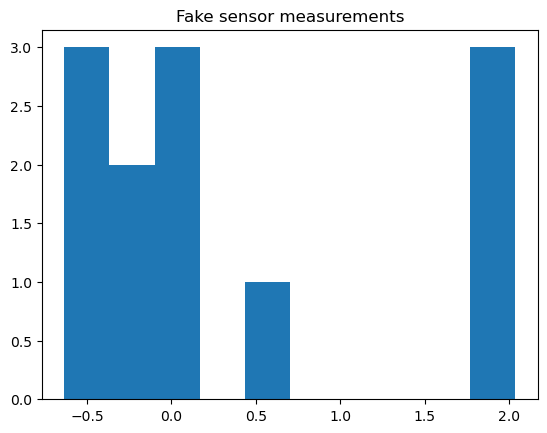

In [388]:
z_sensors = z_sensors - np.median(z_sensors)
plt.hist(z_sensors)
plt.title('Fake sensor measurements')

In [389]:
cut_in = 4 # just a parameter to get the leaks towards the middle of the plane

x_leaks = np.random.randint(dim_lim_low+cut_in, dim_lim_high-cut_in, size=num_of_leaks)
y_leaks = np.random.randint(dim_lim_low+cut_in, dim_lim_high-cut_in, size=num_of_leaks)

#### Quick Plot

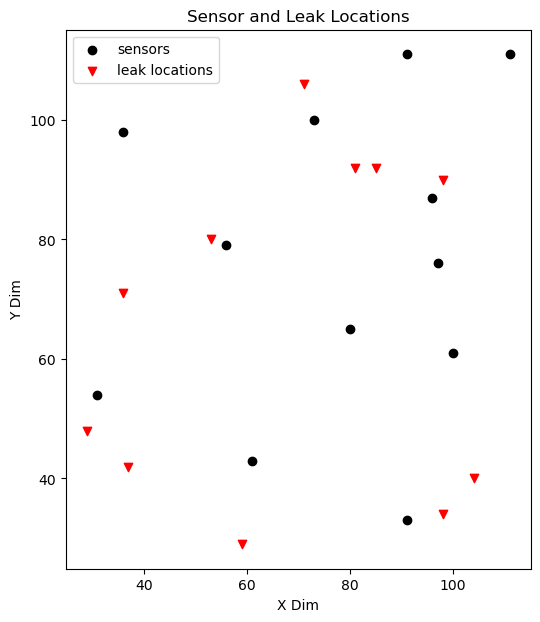

In [390]:
plt.figure(figsize=(6, 7))

plt.scatter(x_sensors, y_sensors, label='sensors', color='black')
plt.scatter(x_leaks, y_leaks, marker="v", label='leak locations', color='red')

plt.legend()
plt.xlabel('X Dim')
plt.ylabel('Y Dim')
plt.title('Sensor and Leak Locations')

plt.show()

This is just for this toy problem, won't be used for the actual code as it will come from the data loader as built by C Becker.

## Interpolate the Data

First step is creating a new meshgrid that is more dense

In [391]:
def create_meshgrid(x_sensors, y_sensors, buffer=6, grid_points=100):
    """
    Create a meshgrid based on sensor positions.

    Parameters:
    - x_sensors (array-like): x-coordinates of sensor positions.
    - y_sensors (array-like): y-coordinates of sensor positions.
    - buffer (float, optional): Buffer value added to the minimum and maximum coordinates for each axis.
    - grid_points (int, optional): Number of grid points in each dimension.

    Returns:
    - x_new (ndarray): Meshgrid for x-coordinates.
    - y_new (ndarray): Meshgrid for y-coordinates.
    """
    x_new, y_new = np.mgrid[min(x_sensors)-buffer:max(x_sensors)+buffer:grid_points*1j, min(y_sensors)-buffer:max(y_sensors)+buffer:grid_points*1j]
    return x_new, y_new

In [392]:
x_new, y_new = create_meshgrid(x_sensors, y_sensors, buffer=6, grid_points=100)

#### Using SciPy griddata

In [393]:
def interpolate_and_find_max(x_sensors, y_sensors, z_sensors, x_new, y_new, method='cubic'):
    """
    Perform 2D interpolation using scipy's griddata and find the global maximum and its indices.

    Parameters:
    - x_sensors (array-like): X-coordinates of the sensor data.
    - y_sensors (array-like): Y-coordinates of the sensor data.
    - z_sensors (array-like): Sensor values corresponding to (x_sensors, y_sensors).
    - x_new (array-like): X-coordinates for which to interpolate.
    - y_new (array-like): Y-coordinates for which to interpolate.
    - method (str, optional): Interpolation method, default is 'cubic'.

    Returns:
    - z_interpolated (ndarray): Interpolated values at the specified coordinates (x_new, y_new).
    - max_z (float): Global maximum value of the interpolated data.
    - max_indices (tuple): Indices of the global maximum in the interpolated data.

    Note:
    - The function uses scipy's griddata for 2D interpolation.
    - The default interpolation method is cubic, but other methods can be specified.
    """
    # Performing 2D interpolation
    z_interpolated = griddata((x_sensors, y_sensors), z_sensors, (x_new, y_new), method=method)

    # Finding Global Max and its indices
    max_z = np.nanmax(z_interpolated)
    max_indices = np.where(z_interpolated == max_z)

    return z_interpolated, max_z, max_indices

In [394]:
%%time 

z_interpolated, max_z, max_indices = interpolate_and_find_max(x_sensors, y_sensors, z_sensors, x_new, y_new, method='cubic')

CPU times: user 3.31 ms, sys: 934 µs, total: 4.24 ms
Wall time: 1.33 ms


#### Using Scikit-learn methods

This uses the scikit-learn API:# Make training data
X_train = np.column_stack((x_sensors, y_sensors))
y_train = z_sensors

In [395]:
# Make training data
X_train = np.column_stack((x_sensors, y_sensors))
y_train = z_sensors

#### Gaussian Processes Regressor

In [396]:
def gaussian_process_interpolation(X_train, y_train, x_new, y_new, length_scale=10):
    """
    Perform Gaussian Process interpolation on the given data.

    Parameters:
    - X_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - x_new (array-like): New data features for interpolation.
    - y_new (array-like): New data labels for interpolation.
    - length_scale (float, optional): Length scale for the RBF kernel. Default is 1.

    Returns:
    - reshaped_gp_results (numpy.ndarray): Interpolated values reshaped to the shape of x_new and y_new.
    - max_z_gp (float): Global maximum value in the interpolated grid.
    - max_indices_gp (tuple): Indices of the global maximum value in the interpolated grid.
    """

    # Define the kernel for Gaussian Process (RBF kernel is used here)
    kernel = RBF(length_scale=length_scale)

    # Create the Gaussian Process Regressor
    gp_model = GaussianProcessRegressor(kernel=kernel)

    # Fit the model with the data
    gp_model.fit(X_train, y_train)

    # Make some test data
    X_test = np.column_stack((x_new.ravel(), y_new.ravel()))

    # Predict interpolated values
    interpolated_values_gp, std = gp_model.predict(X_test, return_std=True)
    reshaped_gp_results = interpolated_values_gp.reshape(x_new.shape)

    # Finding Global Max and its indices using the Gaussian process model
    max_z_gp = np.nanmax(reshaped_gp_results)
    max_indices_gp = np.where(max_z_gp == reshaped_gp_results)

    return reshaped_gp_results, max_z_gp, max_indices_gp

In [397]:
reshaped_gp_results, max_z_gp, max_indices_gp = gaussian_process_interpolation(X_train, y_train, x_new, y_new, length_scale=7)

#### Random Forest Model

Maybe can add wind (U, V, W, etc.) to this model? This should be slow, but might be better for rough / less smooth data sets. 

In [398]:
def random_forest_interpolation(X_train, y_train, x_new, y_new, max_depth=2, n_estimators=50, random_state=42):
    """
    Perform Random Forest interpolation on the given data.

    Parameters:
    - X_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - x_new (array-like): New data features for interpolation.
    - y_new (array-like): New data labels for interpolation.
    - max_depth (int, optional): Maximum depth of the decision trees. Default is 2.
    - n_estimators (int, optional): Number of trees in the forest. Default is 50.
    - random_state (int, optional): Seed for random number generation. Default is 42.

    Returns:
    - reshaped_rf_results (numpy.ndarray): Interpolated values reshaped to the shape of x_new and y_new.
    - max_z_rf (float): Global maximum value in the interpolated grid.
    - max_indices_rf (tuple): Indices of the global maximum value in the interpolated grid.
    """

    # Create the Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    # Fit the model with the data
    rf_model.fit(X_train, y_train)

    # Make some test data
    X_test = np.column_stack((x_new.ravel(), y_new.ravel()))

    # Predict interpolated values
    interpolated_values_rf = rf_model.predict(X_test)
    reshaped_rf_results = interpolated_values_rf.reshape(x_new.shape)

    # Finding Global Max and its indices using the Random Forest model
    max_z_rf = np.nanmax(reshaped_rf_results)
    max_indices_rf = np.unravel_index(np.argmax(reshaped_rf_results), reshaped_rf_results.shape)

    return reshaped_rf_results, max_z_rf, max_indices_rf

In [399]:
reshaped_rf_results, max_z_rf, max_indices_rf = random_forest_interpolation(X_train, y_train, x_new, y_new, max_depth=2)

## Find which sensor has the highest value

In [400]:
def find_closest_value(arr1, arr2):
    closest_values = []

    for val1 in arr1:
        closest_val = min(arr2, key=lambda x: abs(x - val1))
        closest_values.append(closest_val)

    return closest_values

In [401]:
closest_values_x = find_closest_value(x_leaks, x_new[:,0])
closest_values_x

[28.717171717171716,
 59.38383838383838,
 98.41414141414141,
 37.08080808080808,
 80.75757575757575,
 52.878787878787875,
 85.4040404040404,
 103.98989898989899,
 36.151515151515156,
 98.41414141414141,
 70.53535353535354]

In [402]:
closest_values_y = find_closest_value(y_leaks, y_new[0,:])
closest_values_y

[47.90909090909091,
 28.818181818181817,
 89.72727272727272,
 41.54545454545455,
 91.54545454545455,
 79.72727272727272,
 91.54545454545455,
 39.72727272727273,
 70.63636363636363,
 34.27272727272727,
 106.0909090909091]

In [403]:
def find_indices(arr, values_to_find):
    indices = np.concatenate([np.where(arr == val)[0] for val in values_to_find])
    return indices

In [404]:
indices_x = find_indices(x_new[:,0], closest_values_x)
indices_x

array([ 4, 37, 79, 13, 60, 30, 65, 85, 12, 79, 49])

In [405]:
indices_y = find_indices(y_new[0,:], closest_values_y)
indices_y

array([23,  2, 69, 16, 71, 58, 71, 14, 48,  8, 87])

In [406]:
print("Which Leak location is most likely? - Using Standard Interpolator")
index_of_max_value = np.nanargmax(z_interpolated[indices_x, indices_y])
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value)

Which Leak location is most likely? - Using Standard Interpolator
Index of the maximum value (ignoring NaN) is: 5


In [407]:
print("Which Leak location is most likely - Using Gaussian processes?")
index_of_max_value_gp = np.nanargmax(reshaped_gp_results[indices_x, indices_y])
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value_gp)

Which Leak location is most likely - Using Gaussian processes?
Index of the maximum value (ignoring NaN) is: 5


In [408]:
print("Which Leak location is most likely - Using Random Forest?")
index_of_max_value_rf = np.nanargmax(reshaped_rf_results[indices_x, indices_y])
print("Index of the maximum value (ignoring NaN) is:", index_of_max_value_rf)

Which Leak location is most likely - Using Random Forest?
Index of the maximum value (ignoring NaN) is: 9


## Comparison Plot

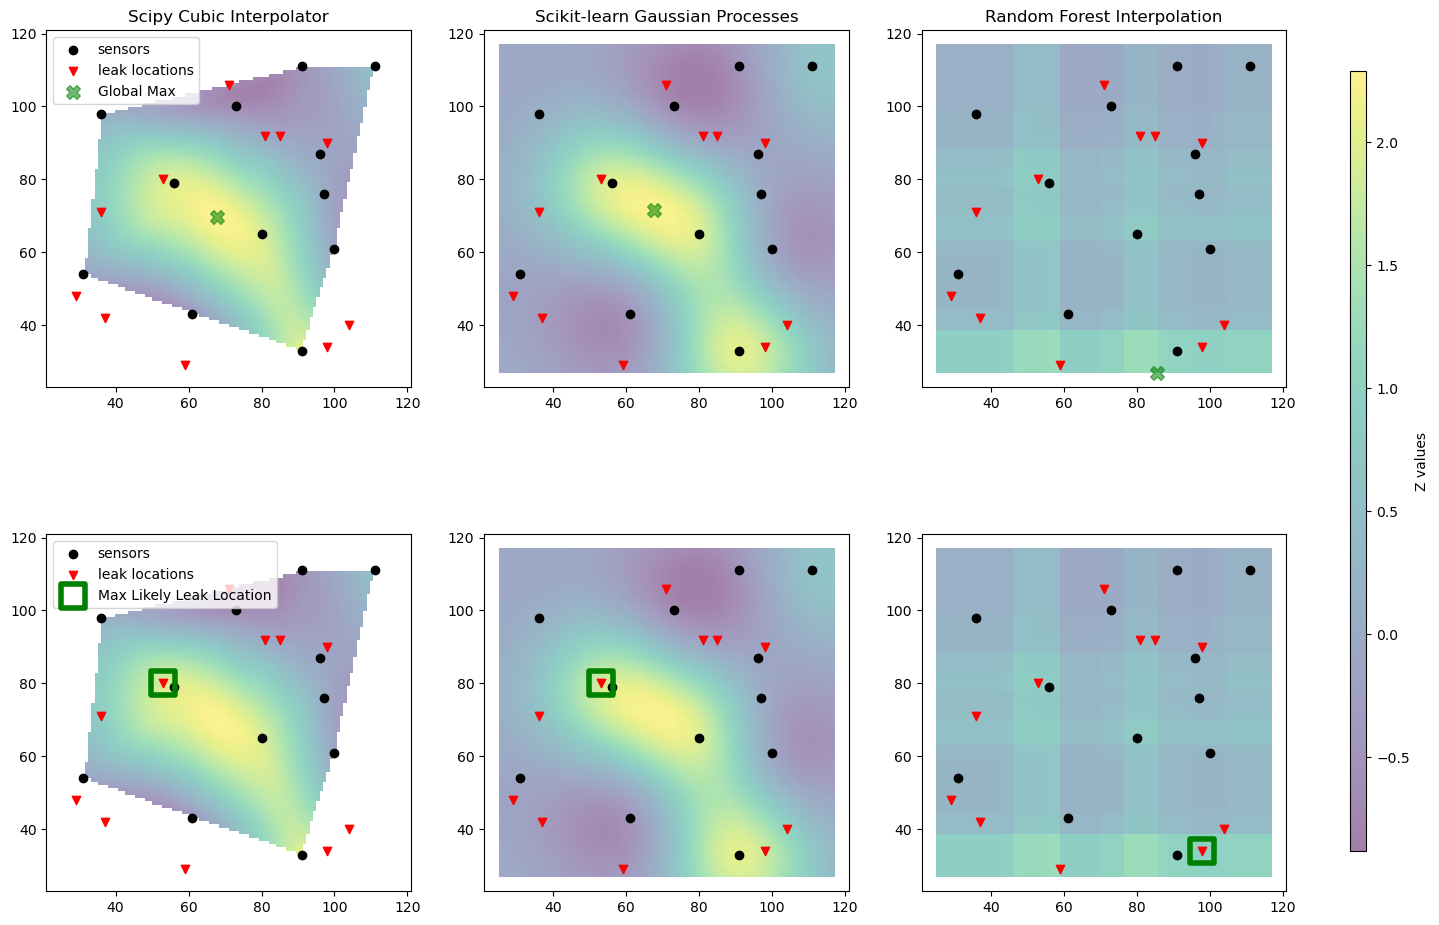

In [409]:
# Calculate the overall minimum and maximum values for the color bar range
buffer = 6

global_min = np.round(np.min(z_sensors),2)-0.25
global_max = np.round(np.max(z_sensors),2)+0.25

fig, axes = plt.subplots(2, 3, figsize=(16, 12))

# Common settings for all subplots
for ax_row in axes:
    for ax in ax_row:
        ax.scatter(x_sensors, y_sensors, label='sensors', color='black')
        ax.scatter(x_leaks, y_leaks, marker="v", label='leak locations', color='red')
        ax.set_xlim(min(x_sensors-buffer-4), max(x_sensors+buffer+4))
        ax.set_ylim(min(y_sensors-buffer-4), max(y_sensors+buffer+4))
        # ax.set_clim(global_min, global_max)  # Set color bar range

        
# Plot 1 - First Block
img = axes[0,0].imshow(z_interpolated.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img.set_clim(global_min, global_max)  # Set color bar range

axes[0, 0].scatter(x_new[max_indices[0][0]][0], y_new[0][max_indices[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[0, 0].legend()
axes[0, 0].set_title('Scipy Cubic Interpolator')

# Plot 2 - Second Block

img2 = axes[0,1].imshow(reshaped_gp_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img2.set_clim(global_min, global_max) 

axes[0, 1].scatter(x_new[max_indices_gp[0][0]][0], y_new[0][max_indices_gp[1][0]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[0, 1].set_title('Scikit-learn Gaussian Processes')

# Plot 4 - Third Block
img4 = axes[1,0].imshow(z_interpolated.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img4.set_clim(global_min, global_max) 

axes[1, 0].scatter(x_leaks[index_of_max_value], y_leaks[index_of_max_value], marker="s", label='Max Likely Leak Location', color='Green', facecolors='none', s=300, linewidths=4)
axes[1, 0].legend()

# Plot 5 - Fourth Block
img5 = axes[1,1].imshow(reshaped_gp_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img5.set_clim(global_min, global_max) 
axes[1, 1].scatter(x_leaks[index_of_max_value_gp], y_leaks[index_of_max_value_gp], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)

# Third Across
img3 = axes[0,2].imshow(reshaped_rf_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img3.set_clim(global_min, global_max) 

axes[0, 2].scatter(x_new[max_indices_rf[0]][0], y_new[0][max_indices_rf[1]], marker="X", label='Global Max', color='Green', s=100, alpha=0.55)
axes[0, 2].set_title('Random Forest Interpolation')

# Third Across, second row
img6 = axes[1,2].imshow(reshaped_rf_results.T, extent=(min(x_sensors-buffer), max(x_sensors+buffer), min(y_sensors-buffer), max(y_sensors+buffer)),
                        origin='lower', cmap='viridis', alpha=0.5)

img6.set_clim(global_min, global_max) 

axes[1, 2].scatter(x_leaks[index_of_max_value_rf], y_leaks[index_of_max_value_rf], marker="s", label='Max Likely Sensor', color='Green', facecolors='none', s=300, linewidths=4)


# Add colorbar
cbar_ax = fig.add_axes([.94, 0.17, 0.01, 0.65])  # [x, y, width, height]
cbar = plt.colorbar(img, cax=cbar_ax)
cbar.set_label('Z values')

# plt.tight_layout()
plt.show()